# PID Tuning using GA

In [10]:
import numpy as np
import control
import matplotlib.pyplot as plt
import math
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.pntx import PointCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

### Define the optimization problem for PID controller

$TF=\frac{K_ds^2+K_ps+K_i}{s^3+(K_d+10)s^2+(K_p+20)s+K_i}$

In [11]:
# Transfer function of the PID controller
def transfer_function(Kp,Ki,Kd):
    num = np.array([Kd,Kp,Ki])
    den = np.array([1,(Kd+10),(Kp+20),Ki])
    T = control.tf(num, den)
    t, y = control.step_response(T)
    return T, t, y

### Define objective function

In [12]:
def objective_function(t, error, Kp,Ki,Kd, criterion):

    if criterion == 1:
        # ITAE (Integral Time Absolute Error)
        ITAE = np.trapz(t, t*error)
        objfnc= ITAE
    elif criterion == 2:
        # ITSE (Integral Time Square Error)
        ITSE = np.trapz(t, t*error**2)
        objfnc= ITSE
    elif criterion == 3:
        # IAE (Integral Absolute Error)
        IAE =  np.trapz(t, error)
        objfnc= IAE
    elif criterion == 4:
        # ISE (Integral Squared Error)
        ISE = np.trapz(t, error**2)
        objfnc= ISE
    elif criterion == 5:
        T, _, _ =transfer_function(Kp,Ki,Kd)
        info = control.step_info(T)
        beta = 1
        Mp = info['Overshoot']
        tr = info['RiseTime']
        ts = info['SettlingTime']
        ess = abs(1-info['SteadyStateValue'])
        W = ((1-math.exp(-beta))*(Mp+ess))+((math.exp(-beta))*(ts-tr))
        objfnc=W;      
        
    return objfnc

In [13]:
class PIDProblem(Problem):

    def __init__(self):
        super().__init__(n_var=3,
                         n_obj=1,
                         n_constr=0,
                         xl=0,
                         xu=100, vtype=float)    

    def _evaluate(self, X, out, *args, **kwargs):
        f = np.zeros((X.shape[0], 1))   
        for i, params in enumerate(X):
            Kp, Ki, Kd = params
            T, t, y =transfer_function(Kp,Ki,Kd)
            error = 1 - y
            f[i]=objective_function(t, np.abs(error), Kp,Ki,Kd, 5)
            
        out["F"] = f

### Define the solver and run for the PID problem

In [14]:
problem = PIDProblem()

algorithm = GA(
    pop_size=50,
    sampling=FloatRandomSampling(),
    crossover=PointCrossover(prob=0.8, n_points=2),
    mutation = PolynomialMutation(prob=0.3, repair=RoundingRepair()),
    eliminate_duplicates=True
)

res = minimize(problem, algorithm, ('n_gen', 60), seed=1, verbose=True)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       50 |  5.6051809480 |  0.3169471710
     2 |      100 |  1.0155865528 |  0.3054194542
     3 |      150 |  0.5555432080 |  0.3054194542
     4 |      200 |  0.3874277859 |  0.2774022724
     5 |      250 |  0.3398688616 |  0.2774022724
     6 |      300 |  0.3186410488 |  0.2774022724
     7 |      350 |  0.2951772482 |  0.2243011434
     8 |      400 |  0.2826954055 |  0.2132911618
     9 |      450 |  0.2644919227 |  0.1056909273
    10 |      500 |  0.2515627977 |  0.1056909273
    11 |      550 |  0.2263186901 |  0.0979887859
    12 |      600 |  0.2014200160 |  0.0854094978
    13 |      650 |  0.1801004250 |  0.0843328972
    14 |      700 |  0.1542581846 |  0.0843328972
    15 |      750 |  0.1283395921 |  0.0697875098
    16 |      800 |  0.1119524283 |  0.0697875098
    17 |      850 |  0.0979695273 |  0.0602709428
    18 |      900 |  0.0933380276 |  0.0602709428
    19 |      950 |  0.0910727958 |  0.0602709428


### Print the results

In [15]:
best_params = res.X
print("Optimal PID controller parameters:")
print("Kp =", best_params[0])
print("Ki =", best_params[1])
print("Kd =", best_params[2])

Optimal PID controller parameters:
Kp = 49
Ki = 95
Kd = 2


### Visualize the time response

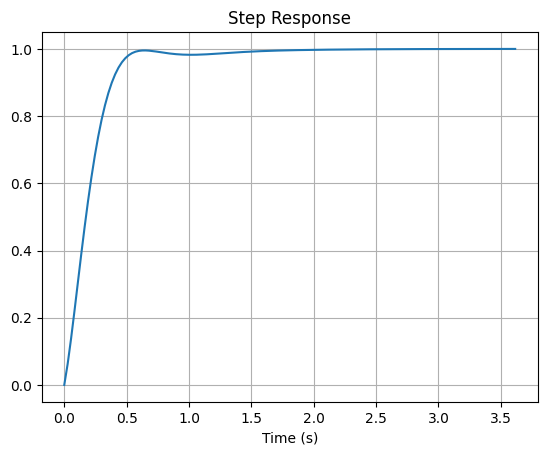

In [16]:
Kp = best_params[0]
Ki = best_params[1]
Kd = best_params[2]

T, t, y =transfer_function(Kp,Ki,Kd)

plt.plot(t,y)
plt.title("Step Response")
plt.xlabel("Time (s)")
plt.grid()
# plt.savefig('CH08_F19.png', format='png', dpi=300)

### Step response characteristics (Rise time, Settling Time, Peak and others)

In [17]:
control.step_info(T)

{'RiseTime': 0.3533999009039424,
 'SettlingTime': 0.5165075474749927,
 'SettlingMin': 0.9241426860361831,
 'SettlingMax': 1.0,
 'Overshoot': 0,
 'Undershoot': 0,
 'Peak': 0.9998667165836661,
 'PeakTime': 3.6155528323249495,
 'SteadyStateValue': 1.0}

### Check stability  [Optional]

<i>Asymptotically Stable System</i>
* All the poles ley in the left half plane
* All real parts of the poles are negative

<i>Marginally Stable System</i>
* Poles coincide in the imaginary axis

<i>Unstable System</i>
* At least one pole lies in the right half plane (has real part greater than zero). 

<i>Note</i>: Transfer function poles refer to the values of the complex variable in the Laplace domain, denoted as 's', that cause the denominator of the transfer function to become zero. While transfer function zeros refer to the values of the complex variable in the Laplace domain that cause the numerator of the transfer function to become zero. 

### Stability Analysis ####
p = [-5.04471659+4.9268954j -5.04471659-4.9268954j -1.91056682+0.j       ]
Asymptotically Stable System


(array([-5.04471659+4.9268954j, -5.04471659-4.9268954j,
        -1.91056682+0.j       ]),
 array([-22.37731455+0.j,  -2.12268545+0.j]))

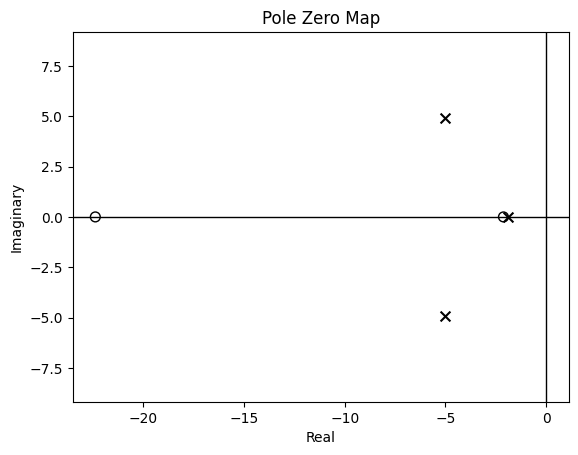

In [18]:
# Poles
p = control.pole(T)

print("### Stability Analysis ####")
print ('p =', p)

if np.all(np.real(p)<0): 
    print("Asymptotically Stable System")
elif np.any(np.real(p)==0):
    print("Marginally Stable System")
else:
    print("Unstable System")

# Visualize poles and zeros using pole-zero plot. Cross represents pole and circule represent zero
control.pzmap(T)